In [1]:
#HSV segmentation

In [2]:
%matplotlib inline

/Users/rolland/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from matplotlib import pyplot as plt
from skimage import data,color, exposure,feature,io
from math import sqrt
from skimage.color import rgb2gray
import skimage.exposure as imexp
from skimage.filters import gabor_kernel
from PIL import Image
from scipy import ndimage as ndi
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from matplotlib import style

style.use('ggplot')

In [4]:
#loading data

In [5]:
# im1 = Image.open('onlineSamples/textures/1.jpg')
# im2 = Image.open('onlineSamples/textures/2.jpg')
# im3 = Image.open('onlineSamples/textures/3.jpg')



onlineSamples = []
onlineHsvSamples = []

imgSamples = [];
imgHsvSamples = [];



# npimg1 = np.array(im1)
# npimg2 = np.array(im2)
# npimg3 = np.array(im3)

# img_hsv1 = color.rgb2hsv(npimg1)
# img_hsv2 = color.rgb2hsv(npimg2)
# img_hsv3 = color.rgb2hsv(npimg3)


for a in range(0,3):
    onlineSamples.append(np.array(Image.open('onlineSamples/textures/'+str(a+1)+'.jpg')))
                      
for b in range(0,3):
    onlineHsvSamples.append(color.rgb2hsv(onlineSamples[b]))

for c in range(0,18):
    imgSamples.append(np.array(Image.open('renamed-samples1/'+str(c+1)+'.bmp')))
                      
for d in range(0,18):
    imgHsvSamples.append(color.rgb2hsv(imgSamples[d]))


print(len(imgSamples))  
print(len(imgHsvSamples))  
print(len(onlineSamples))  
print(len(onlineHsvSamples))  
print(imgSamples[0].shape);
print(imgHsvSamples[0].shape)


18
18
3
3
(1080, 1920, 3)
(1080, 1920, 3)


In [6]:
#plotting

In [7]:
##saturation thresholding

In [8]:
def satThreshold(v,s):    ##return hue or intensity as dominant feature
    th = 1.0 - 0.8*v;
    if(s>th):
        return "h"
    else: 
        return "v"
    

In [9]:
def approximate(img):
    tmpImg = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            dominantVal = satThreshold(img[i,j,2],img[i,j,1])
#             print("dominantVal----"+dominantVal)
            tmpImg[i,j,:] = img[i,j,:]
            if dominantVal == "h":
                tmpImg[i,j,0] = img[i,j,0]
                tmpImg[i,j,1] = 1.0
                tmpImg[i,j,2] = 1.0
                
            else:
                tmpImg[i,j,0] = 1.0
                tmpImg[i,j,1] = 1.0
                tmpImg[i,j,2] = img[i,j,2]
        
    return tmpImg

In [10]:
##ploating online samples

In [11]:
##extrac main component

In [12]:
def extractMainComp(approx_img):
    #0.12 green , #0.67 blue , #0,1 red
      return ( (approx_img[:,:,0] < 0.3))

In [13]:
##renyi antropy

In [14]:
def extractMainHsvComp(approx_img,hsv_img):
    
    tmpImg = np.zeros(hsv_img.shape)
    for i in range(hsv_img.shape[0]):
        for j in range(hsv_img.shape[1]):
            tmpImg[i,j,:] = hsv_img[i,j,:]
            if  not approx_img[i,j]: #turn to black
                tmpImg[i,j,0] = 0.
                tmpImg[i,j,1] = 0.
                tmpImg[i,j,2] = 0.      
        
    return tmpImg

In [15]:
##extract main hsv component based on approximated image result

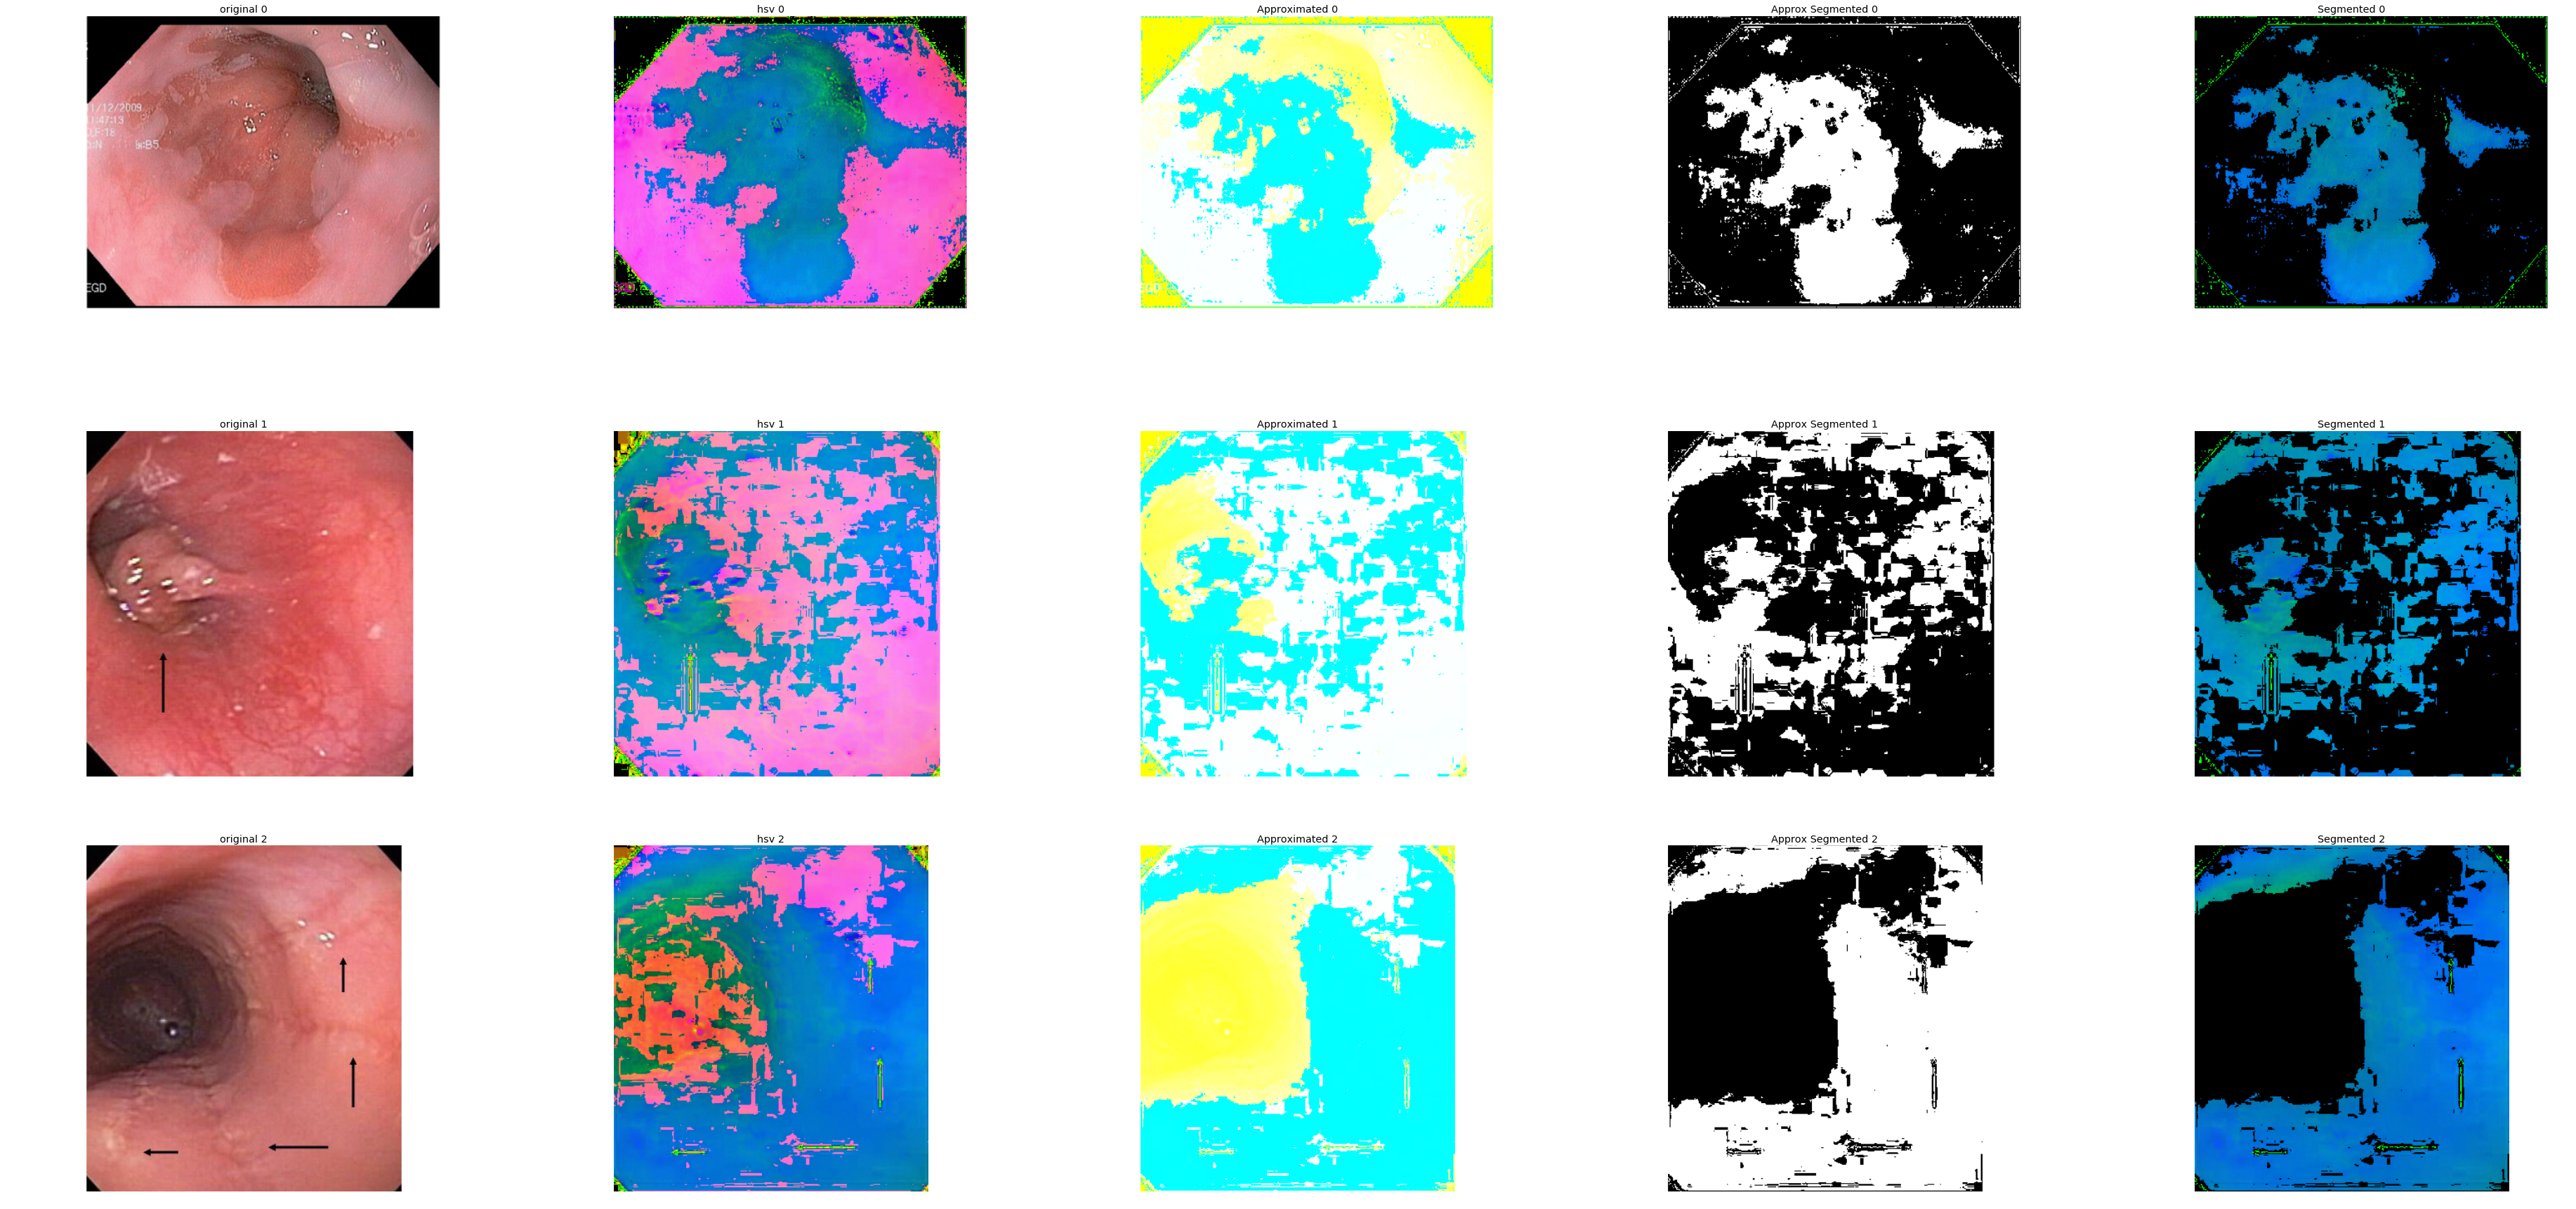

In [16]:
colnum = 5
# rownum = int(math.floor((float(len(imgSamples))/ float(colnum))+1))
rownum = len(onlineSamples)
# print(rownum)


fig, axes = plt.subplots(rownum, colnum, figsize=(65, rownum*10), sharex=True, sharey=True)
ax = axes.ravel()
index = 0

for i in range(0, len(onlineHsvSamples)):
    
    ax[index].imshow(onlineSamples[i],cmap='gray')
    ax[index].set_title("original "+str(i))
    ax[index].axis('off') 
    
    ax[index+1].imshow(onlineHsvSamples[i],cmap='gray')
    ax[index+1].set_title("hsv "+str(i))
    ax[index+1].axis('off') 
    
    ax[index+2].imshow(approximate(onlineHsvSamples[i]),cmap='gray')
    ax[index+2].set_title("Approximated "+str(i))
    ax[index+2].axis('off') 
    
    ax[index+3].imshow(extractMainComp(approximate(onlineHsvSamples[i])),cmap='gray')
    ax[index+3].set_title("Approx Segmented "+str(i))
    ax[index+3].axis('off')
    
    
    approximatedSeg = extractMainComp(approximate(onlineHsvSamples[i]))
    hsvSegmented = extractMainHsvComp(approximatedSeg,onlineHsvSamples[i])
    ax[index+4].imshow(hsvSegmented,cmap='gray')
    ax[index+4].set_title("Segmented "+str(i))
    ax[index+4].axis('off') 
    
    index +=5
    
plt.show()

In [17]:
###Gabor filter


def filterImage(image, kernels):
    feats = np.zeros((len(kernels), 2),np.uint8)
    filtered = []
    for k, kernel in enumerate(kernels):
        filtered.append(ndi.convolve(image, kernel, mode='wrap'))
#         feats[k, 0] = filtered.mean()
#         feats[k, 1] = filtered.var()
    return filtered

In [18]:
def compute_feats(image):
    feats = np.zeros((image.shape[0],image.shape[1],2),np.uint8)
    
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = image[max(i-1,0):min(i+1,image.shape[0]-1),max(j-1,0):min(j+1,image.shape[1]-1)]
            feats[i,j, 0] = window.mean()
            feats[i,j, 1] = window.var()
 
    return feats

In [19]:
def mass_compute_feats(images):
    feats = np.zeros((images[0].shape[0],images[0].shape[1],2*len(images)))
    feat_index = 0;
    
    for image in images:
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                window = image[max(i-1,0):min(i+1,image.shape[0]-1),max(j-1,0):min(j+1,image.shape[1]-1)]
       
                feats[i,j, feat_index] = window.mean()
                feats[i,j, feat_index+1] = window.var()
                
        feat_index+=2
 
    return feats

In [20]:
def mass_compute_feats2(images):
    feats = np.zeros((images[0].shape[0],images[0].shape[1],len(images)))
    
    for k in range(len(images)):
        for i in range(images[k].shape[0]):
            for j in range(images[k].shape[1]):
                
                feats[i,j, k] = images[k][i,j]
        
#     print("images[0].shape[0]----",images[0].shape[0])   
 
    return feats

In [21]:
def mass_compute_feats3(images):
    feats = np.zeros((images[0].shape[0],images[0].shape[1],2*len(images)))
    
    
    for k in range(len(images)):
        for i in range(images[k].shape[0]):
            for j in range(images[k].shape[1]):
                window = images[k][max(i-1,0):min(i+1,images[k].shape[0]-1),max(j-1,0):min(j+1,images[k].shape[1]-1)]
                
                feats[i,j, 2*k] = np.sum(np.square(window))
                feats[i,j, 2*k+1] = np.sum(window)
                
#                 feats[i,j, k] = images[k][i,j]
        
#     print("images[0].shape[0]----",images[0].shape[0])   
 
    return feats

In [22]:
def add_color_feats(hsvImg,grayScaleFeats):
    newDim =  grayScaleFeats.shape[2]+3
    newFeats = np.zeros((hsvImg.shape[0],hsvImg.shape[1],newDim))
    print('preparig to merge feats----')
#     print(grayScaleFeats[50,50])
#     print(grayScaleFeats[50,50,0])
#     print(grayScaleFeats[50,50,5])
#     print(grayScaleFeats.shape)
    
    for k in range(grayScaleFeats.shape[0]):
        for l in range(grayScaleFeats.shape[1]):
            for h in range(newDim-3):
                newFeats[k,l,h] = grayScaleFeats[k,l,h]
#                 print(newFeats[k,l,h])
            newFeats[k,l,newDim-3] = hsvImg[k,l,0]
#             print(newFeats[k,l,newDim-3])
            newFeats[k,l,newDim-2] = hsvImg[k,l,1]
#             print(newFeats[k,l,newDim-2])
            newFeats[k,l,newDim-1] = hsvImg[k,l,2]
#             print(newFeats[k,l,newDim-1])
                
    print('combined feats----')
    print(len(newFeats[0,0,:]))
#     print(newFeats[100,100])
#     print(newFeats[50,50])

 
    return newFeats

In [23]:
###k-means for features


####k-means class



class K_Means_Feats:
    def __init__(self, k=3, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.rgbColors = np.array([[0,255,0],[0,0,255],[255,0,0],[255,255,0],[160,32,240],[238,130,238]])
        self.rgbColors.astype(float)
#        white, green, ,red, yellow, purple,violet


    def fit(self,img):

        self.centroids = {}
        
        tempImg = img
        ###assign initial centroids
        for i in range(self.k):
            self.centroids[i] = img[0,i,:]
            
        print("centroids----")
#         print(self.centroids)

        for i in range(self.max_iter):
            self.clusters = {}
            self.clustersIndeces = {}
                ##classes holder
            for i in range(self.k):
                self.clusters[i] = []
                self.clustersIndeces[i] = []
        
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    distances = [np.linalg.norm(img[i,j,:]-self.centroids[centroid]) for centroid in self.centroids]
                    clust_index = distances.index(min(distances))
                    self.clustersIndeces[clust_index].append([i,j])
                    self.clusters[clust_index].append(img[i,j,:])
                    
                    
            prev_centroids = dict(self.centroids)         
            
            
            
            ##  re-assign centroids 
            for item in self.clusters:
                self.centroids[item] = np.average(self.clusters[item],axis=0)

            optimized = True
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/((original_centroid)*100.0)) > self.tol:
                    optimized = False

            if optimized:
                break
        
        output = np.zeros((img.shape[0],img.shape[1],3),np.uint8); 
        
                
        for cent in self.centroids:
            for pair in self.clustersIndeces[cent]:
                output[pair[0],pair[1],0] = self.rgbColors[cent][0]
                output[pair[0],pair[1],1] = self.rgbColors[cent][1]
                output[pair[0],pair[1],2] = self.rgbColors[cent][2]
                
        self.output  = output  

In [24]:
# prepare filter bank kernels
kernels = []

for theta in np.arange(0, np.pi, np.pi / 6):
    for sigma in (1.0,1.25,1.5):  #gausian kernel window size
        for frequency in (0.1, 0.2):
#              0 < FL(i) < 0.25 and 0.25 ≤ FH (i) < 0.5.
            kernel = np.real(gabor_kernel(frequency, theta=theta,sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [25]:
# # prepare filter bank kernels
# kernels = []
# for theta in range(4):
#     theta = theta / 4. * np.pi
#     for frequency in (0.05, 0.25):
#         kernel = np.real(gabor_kernel(frequency, theta=theta,sigma_x=2, sigma_y=2))
#         kernels.append(kernel)

len(filtredImg)
36
(352, 424)
centroids----
preparig to merge feats----
combined feats----
39
centroids----
preparig to merge feats----
combined feats----
75
centroids----
preparig to merge feats----
combined feats----
75
centroids----
centroids----
preparig to merge feats----
combined feats----
39
centroids----
len(filtredImg)
36
(426, 392)
centroids----
preparig to merge feats----
combined feats----
39
centroids----
preparig to merge feats----
combined feats----
75
centroids----
preparig to merge feats----
combined feats----
75
centroids----
centroids----
preparig to merge feats----
combined feats----
39
centroids----
len(filtredImg)
36
(416, 378)
centroids----
preparig to merge feats----
combined feats----
39
centroids----
preparig to merge feats----
combined feats----
75
centroids----
preparig to merge feats----
combined feats----
75
centroids----
centroids----
preparig to merge feats----
combined feats----
39
centroids----


/Users/rolland/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


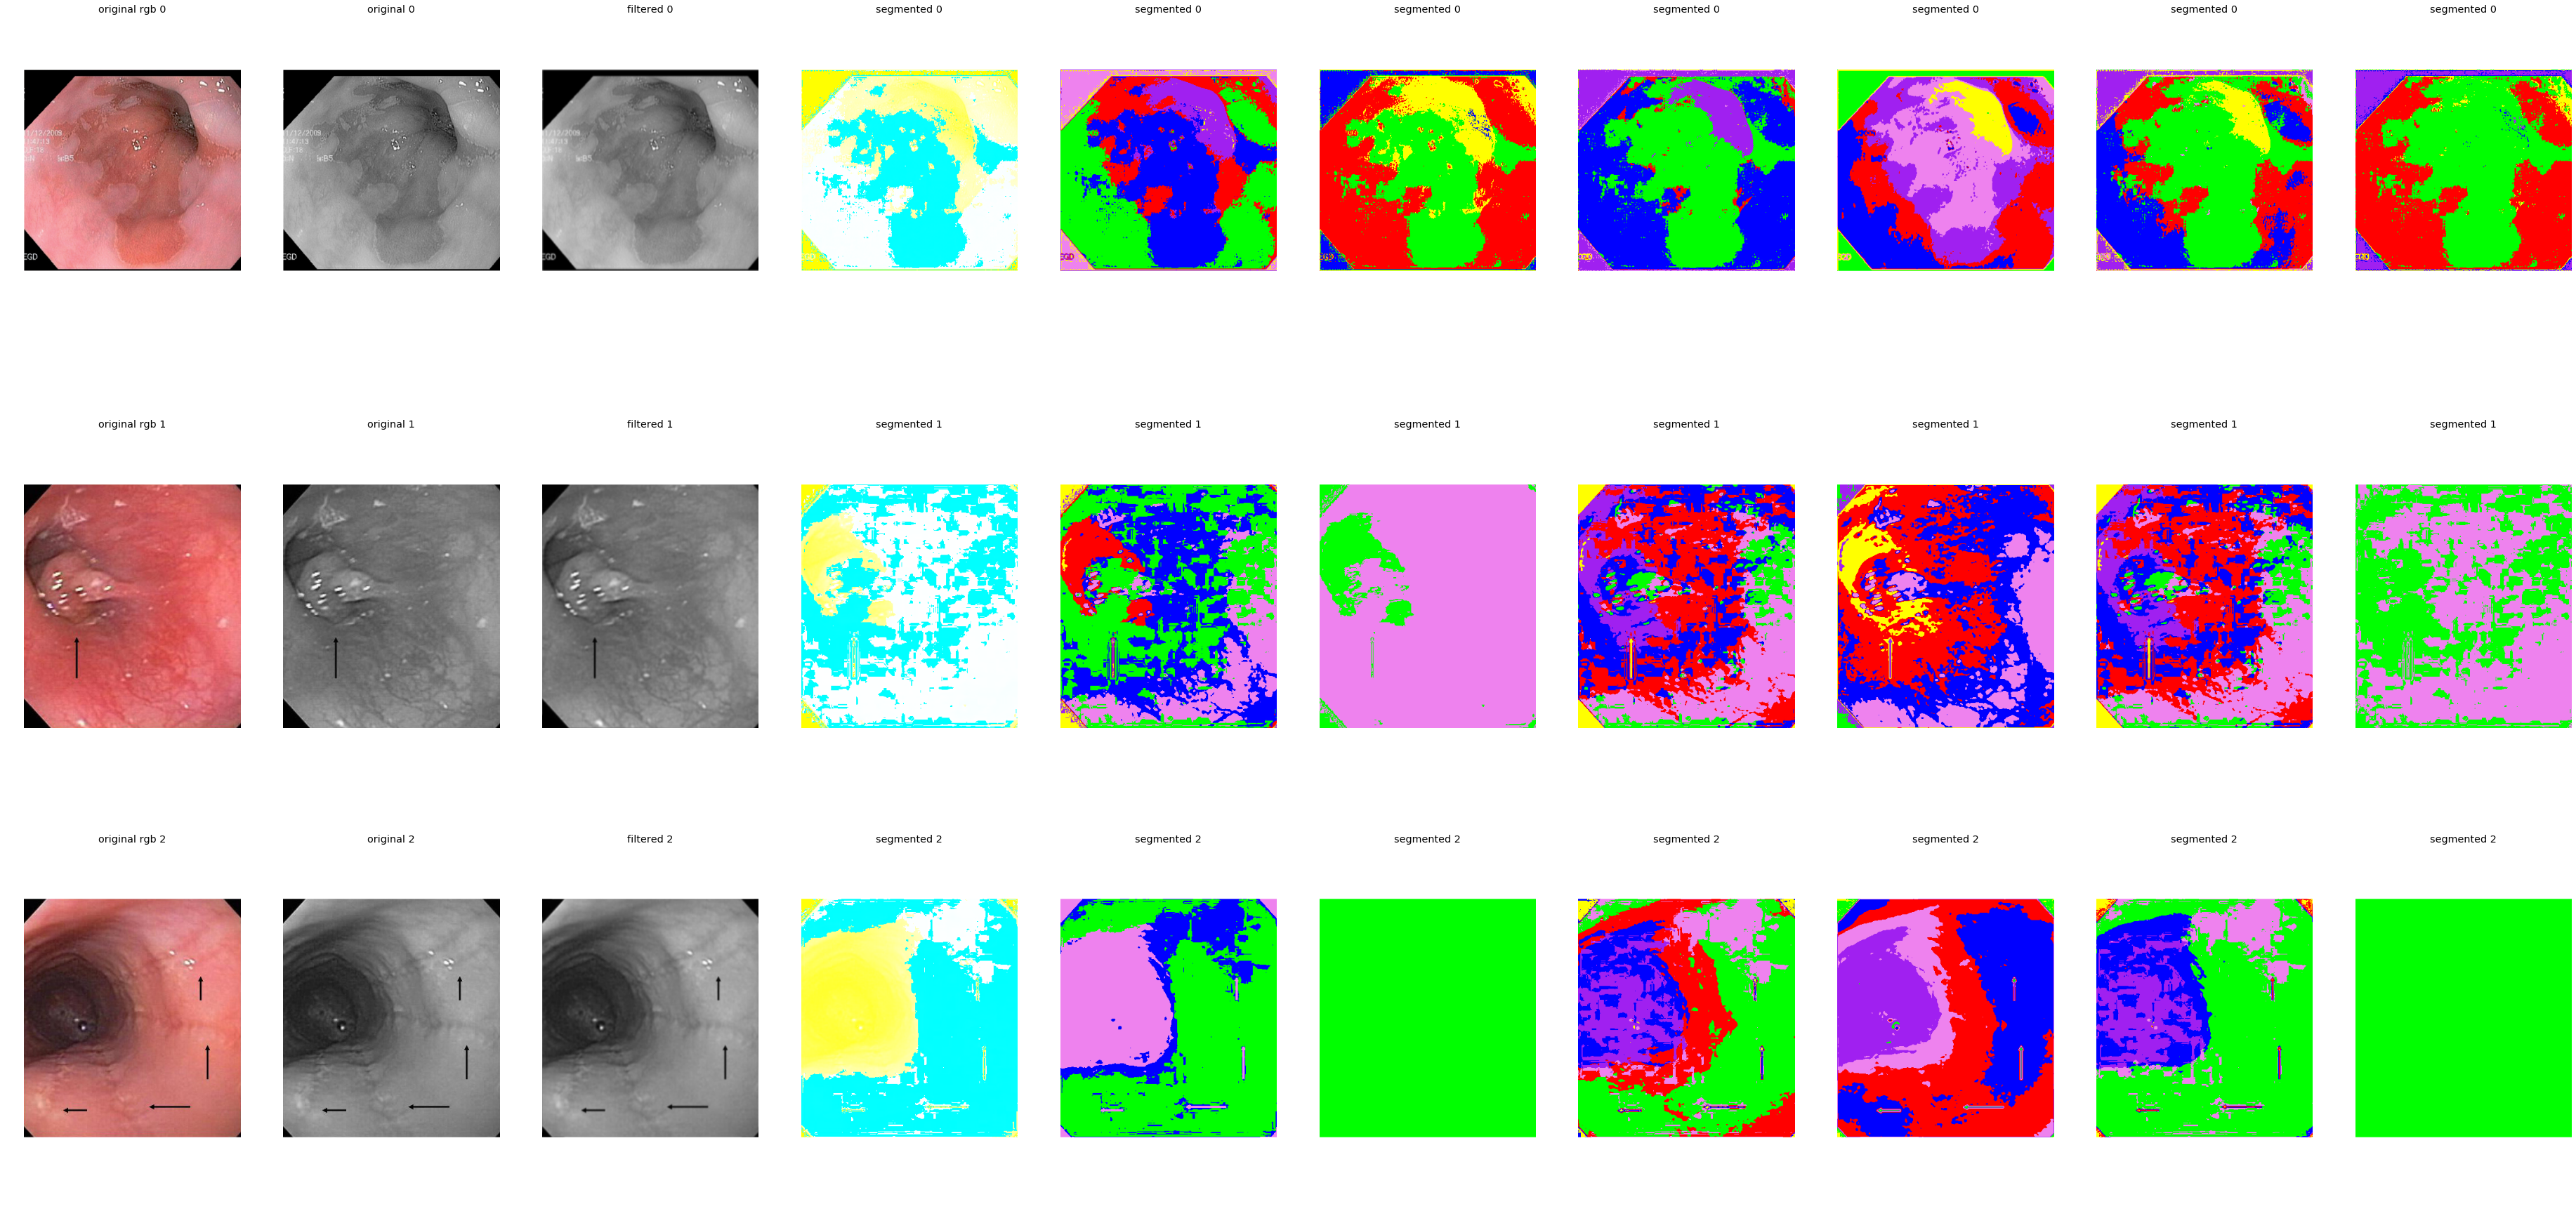

In [26]:
colnum = 10
# rownum = int(math.floor((float(len(imgSamples))/ float(colnum))+1))
rownum = len(onlineSamples)
# print(rownum)



fig, axes = plt.subplots(rownum, colnum, figsize=(65, rownum*10), sharex=True, sharey=True)
ax = axes.ravel()
index = 0

kmeanf = K_Means_Feats(k=6)
kmeanf2 = K_Means_Feats(k=6)
kmeanf3 = K_Means_Feats(k=6)
kmeanf4 = K_Means_Feats(k=6)
kmeanf5 = K_Means_Feats(k=6)
kmeanf6 = K_Means_Feats(k=6)
    

for i in range(0, len(onlineHsvSamples)):
    
    imgToFilter = rgb2gray(onlineSamples[i])
    
    filtredImg = filterImage(imgToFilter,kernels)
    
    print("len(filtredImg)")
    print(len(filtredImg))
    print(filtredImg[0].shape)
    
    ax[index].imshow(onlineSamples[i],cmap='gray')
    ax[index].set_title("original rgb "+str(i))
    ax[index].axis('off') 
    
    ax[index+1].imshow(imgToFilter,cmap='gray')
    ax[index+1].set_title("original "+str(i))
    ax[index+1].axis('off') 
    
    ax[index+2].imshow(filtredImg[0],cmap='gray')
    ax[index+2].set_title("filtered "+str(i))
    ax[index+2].axis('off')

            
     
    kmeanf.fit(onlineHsvSamples[i])  
    kmeanf2.fit(add_color_feats(onlineHsvSamples[i],mass_compute_feats2(filtredImg))) 
    kmeanf3.fit(add_color_feats(onlineHsvSamples[i],mass_compute_feats3(filtredImg))) 
    kmeanf4.fit(add_color_feats(onlineHsvSamples[i],mass_compute_feats(filtredImg))) 
    kmeanf5.fit(approximate(onlineHsvSamples[i])) 
    kmeanf6.fit(add_color_feats(approximate(onlineHsvSamples[i]),mass_compute_feats2(filtredImg))) 
    

    ax[index+3].imshow(approximate(onlineHsvSamples[i]),cmap='gray')
    ax[index+3].set_title("segmented "+str(i))
    ax[index+3].axis('off')
    
    ax[index+4].imshow(kmeanf6.output,cmap='gray')
    ax[index+4].set_title("segmented "+str(i))
    ax[index+4].axis('off')
    
    ax[index+5].imshow(kmeanf5.output,cmap='gray')
    ax[index+5].set_title("segmented "+str(i))
    ax[index+5].axis('off')
    
    ax[index+6].imshow(kmeanf4.output,cmap='gray')
    ax[index+6].set_title("segmented "+str(i))
    ax[index+6].axis('off')
    
    ax[index+7].imshow(kmeanf3.output,cmap='gray')
    ax[index+7].set_title("segmented "+str(i))
    ax[index+7].axis('off')
    
    ax[index+8].imshow(kmeanf2.output,cmap='gray')
    ax[index+8].set_title("segmented "+str(i))
    ax[index+8].axis('off')
            
    ax[index+9].imshow(kmeanf.output,cmap='gray')
    ax[index+9].set_title("segmented "+str(i))
    ax[index+9].axis('off')
    index += colnum
    
plt.show()

In [ ]:
###k-means for images


####k-means class



class K_Means_img:
    def __init__(self, k=3, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.rgbColors = np.array([[0,255,0],[0,0,255],[255,0,0],[255,255,0],[160,32,240],[238,130,238]])
        self.rgbColors.astype(float)
#        white, green, ,red, yellow, purple,violet


    def fit(self,img):

        self.centroids = {}
        
        tempImg = img
        ###assign initial centroids
        for i in range(self.k):
            self.centroids[i] = img[0,i,:]
            
        print("centroids----")
#         print(self.centroids)

        for i in range(self.max_iter):
            self.clusters = {}
            self.clustersIndeces = {}
                ##classes holder
            for i in range(self.k):
                self.clusters[i] = []
                self.clustersIndeces[i] = []
                
                

#             for featureset in data:
#                 distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
#                 classification = distances.index(min(distances))
#                 self.classifications[classification].append(data.index(featureset))

#             prev_centroids = dict(self.centroids)
            
            
        
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    distances = [np.linalg.norm(img[i,j,:]-self.centroids[centroid]) for centroid in self.centroids]
                    clust_index = distances.index(min(distances))
                    self.clustersIndeces[clust_index].append([i,j])
                    self.clusters[clust_index].append(img[i,j,:])
                    
#                     print("pix i,j---")
#                     print(img[i,j])
            
            prev_centroids = dict(self.centroids)         
            
            
            
            ##  re-assign centroids 
            for item in self.clusters:
                self.centroids[item] = np.average(self.clusters[item],axis=0)

            optimized = True
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/(original_centroid*100.0)) > self.tol:
                    optimized = False

            if optimized:
                break
        
        output = np.zeros(img.shape, np.uint8); 
        
                
        for cent in self.centroids:
            for pair in self.clustersIndeces[cent]:
                output[pair[0],pair[1],0] = self.rgbColors[cent][0]
                output[pair[0],pair[1],1] = self.rgbColors[cent][1]
                output[pair[0],pair[1],2] = self.rgbColors[cent][2]
#                   output[pair[0],pair[1]] = self.centroids[cent]
                
#                 print("assigning colors---")
#                 print(output[pair[0],pair[1]]) 
                
        self.output  = output  

#     def predict(self,data):
#         distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
#         classification = distances.index(min(distances))
#         return classification

In [ ]:
colnum = 10
# rownum = int(math.floor((float(len(imgSamples))/ float(colnum))+1))
rownum = len(imgSamples)
# print(rownum)



fig, axes = plt.subplots(rownum, colnum, figsize=(65, rownum*10), sharex=True, sharey=True)
ax = axes.ravel()
index = 0

kmeanf = K_Means_Feats(k=6)
kmeanf2 = K_Means_Feats(k=6)
kmeanf3 = K_Means_Feats(k=6)
kmeanf4 = K_Means_Feats(k=6)
kmeanf5 = K_Means_Feats(k=6)
kmeanf6 = K_Means_Feats(k=6)
    

for i in range(0, len(imgHsvSamples)):
    
    imgToFilter = rgb2gray(imgSamples[i])
    
    filtredImg = filterImage(imgToFilter,kernels)
    
    print("len(filtredImg)")
    print(len(filtredImg))
    print(filtredImg[0].shape)
    
    ax[index].imshow(imgSamples[i],cmap='gray')
    ax[index].set_title("original rgb "+str(i))
    ax[index].axis('off') 
    
    ax[index+1].imshow(imgToFilter,cmap='gray')
    ax[index+1].set_title("original "+str(i))
    ax[index+1].axis('off') 
    
    ax[index+2].imshow(filtredImg[0],cmap='gray')
    ax[index+2].set_title("filtered "+str(i))
    ax[index+2].axis('off')

            
     
    kmeanf.fit(imgHsvSamples[i])  
    kmeanf2.fit(add_color_feats(imgHsvSamples[i],mass_compute_feats2(filtredImg))) 
    kmeanf3.fit(add_color_feats(imgHsvSamples[i],mass_compute_feats3(filtredImg))) 
    kmeanf4.fit(add_color_feats(imgHsvSamples[i],mass_compute_feats(filtredImg))) 
    kmeanf5.fit(approximate(imgHsvSamples[i])) 
    kmeanf6.fit(add_color_feats(approximate(imgHsvSamples[i]),mass_compute_feats2(filtredImg))) 
    

    ax[index+3].imshow(approximate(imgHsvSamples[i]),cmap='gray')
    ax[index+3].set_title("segmented "+str(i))
    ax[index+3].axis('off')
    
    ax[index+4].imshow(kmeanf6.output,cmap='gray')
    ax[index+4].set_title("segmented "+str(i))
    ax[index+4].axis('off')
    
    ax[index+5].imshow(kmeanf5.output,cmap='gray')
    ax[index+5].set_title("segmented "+str(i))
    ax[index+5].axis('off')
    
    ax[index+6].imshow(kmeanf4.output,cmap='gray')
    ax[index+6].set_title("segmented "+str(i))
    ax[index+6].axis('off')
    
    ax[index+7].imshow(kmeanf3.output,cmap='gray')
    ax[index+7].set_title("segmented "+str(i))
    ax[index+7].axis('off')
    
    ax[index+8].imshow(kmeanf2.output,cmap='gray')
    ax[index+8].set_title("segmented "+str(i))
    ax[index+8].axis('off')
            
    ax[index+9].imshow(kmeanf.output,cmap='gray')
    ax[index+9].set_title("segmented "+str(i))
    ax[index+9].axis('off')
    index += colnum
    
plt.show()

len(filtredImg)
36
(1080, 1920)
centroids----
preparig to merge feats----
combined feats----
39
centroids----
preparig to merge feats----
combined feats----
75
centroids----
preparig to merge feats----
combined feats----
75
centroids----
centroids----
preparig to merge feats----
combined feats----
39
centroids----
len(filtredImg)
36
(1080, 1920)
centroids----
preparig to merge feats----
combined feats----
39
centroids----
preparig to merge feats----
combined feats----
75
centroids----

In [ ]:
# colnum = 5
# # rownum = int(math.floor((float(len(imgSamples))/ float(colnum))+1))
# rownum = len(imgSamples)
# print(rownum)


# fig, axes = plt.subplots(rownum, colnum, figsize=(50, rownum*10), sharex=True, sharey=True)
# ax = axes.ravel()
# index = 0


# for i in range(0, len(imgHsvSamples)):
    
#     ax[index].imshow(imgSamples[i],cmap='gray')
#     ax[index].set_title("ori`ginal "+str(i))
#     ax[index].axis('off') 
    
    
#     ax[index+1].imshow(imgHsvSamples[i],cmap='gray')
#     ax[index+1].set_title("hsv "+str(i))
#     ax[index+1].axis('off') 
    
#     approx = approximate(imgHsvSamples[i])
    
#     ax[index+2].imshow(approx,cmap='gray')
#     ax[index+2].set_title("Approximated "+str(i))
#     ax[index+2].axis('off') 
    
    
#     ax[index+3].imshow(extractMainComp(approx),cmap='gray')
#     ax[index+3].set_title("Segmented "+str(i))
#     ax[index+3].axis('off')   kmeans[i] = K_Means_img(k=6)

#     kmeans[i].fit(imgHsvSamples[i])
#     ax[index+4].imshow(kmeans[i].output,cmap='gray')
#     ax[index+4].set_title("kmean Segmented "+str(i))
#     ax[index+4].axis('off') 
#     index +=5
    
# plt.show()

In [ ]:
##histogram of approximated hvs